<a href="https://colab.research.google.com/github/CI-SSLab/bladder_cancer_tucr_xai/blob/main/Check_batch_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy
!pip install -U matplotlib==3.5.2

In [2]:
import scipy as sp
import h5py
import pandas as pd
import scanpy as sc
from scanpy import AnnData
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import matplotlib

print(matplotlib.__version__)

3.2.2


## Load our dataset

In [9]:
with h5py.File('genes_data.h5', 'r') as fd:
    fd_total = pd.concat([pd.DataFrame(fd[k][:]) for k in fd.keys() if k != 'FD_Labels'])
    fd_total.index = [f'patient_{i}' for i in range(fd_total.shape[0])]

    p = {}
    ci = 0
    for k in fd.keys():
        if k == 'FD_Labels':
            continue
        lk = k.split('_')[-1]
        local_p = {f'patient_{ci + i}': lk for i in range(fd[k].shape[0])}
        p = dict(p, **local_p)
        ci += len(local_p)

ann_fd = AnnData(X=fd_total)
ann_fd.obs['patients_type'] = pd.DataFrame(p, index=[0]).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Compute highly variable genes

In [13]:
sc.pp.highly_variable_genes(ann_fd, min_mean=0.0125, max_mean=3, 
                            min_disp=0.5, batch_key='patients_type')

sum_hv = sum(ann_fd.var.highly_variable_intersection)
print(f"Highly variable genes intersection: {sum_hv}")
print()

print("Number of batches where gene is variable:")
print(ann_fd.var.highly_variable_nbatches.value_counts())
print()

var_genes_batch = ann_fd.var.highly_variable_nbatches > 0
print(f"Summary of presence of variable genes: {any(var_genes_batch)}")


Highly variable genes intersection: 0

Number of batches where gene is variable:
0    1920
Name: highly_variable_nbatches, dtype: int64

Summary of presence of variable genes: False


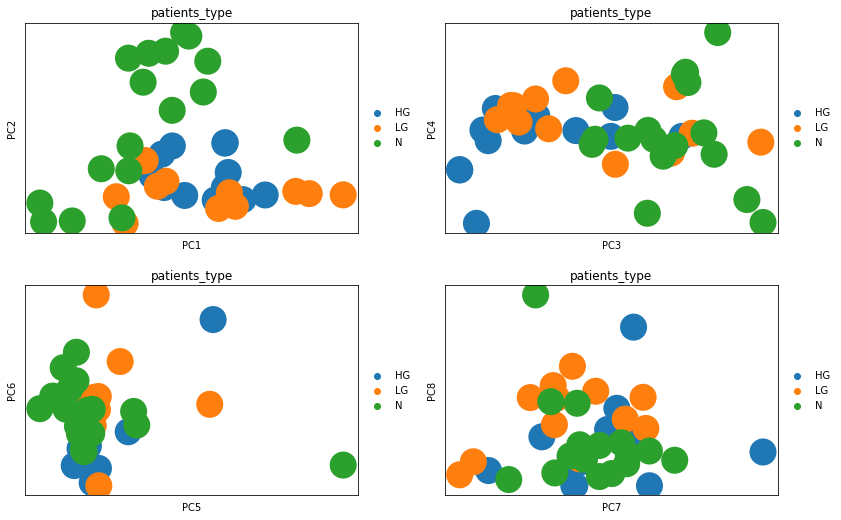

In [ ]:
sc.tl.pca(ann_fd, svd_solver='arpack', use_highly_variable=False)
sc.pl.pca(ann_fd, components=['1,2','3,4','5,6','7,8'], 
          ncols=2, color='patients_type')


In [ ]:
# tSNE
sc.tl.tsne(ann_fd, n_pcs=40)

# UMAP, first with neighbor calculation 
sc.pp.neighbors(ann_fd, n_pcs=40, n_neighbors=20)
sc.tl.umap(ann_fd)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


<AxesSubplot:title={'center':'umap'}, xlabel='UMAP1', ylabel='UMAP2'>

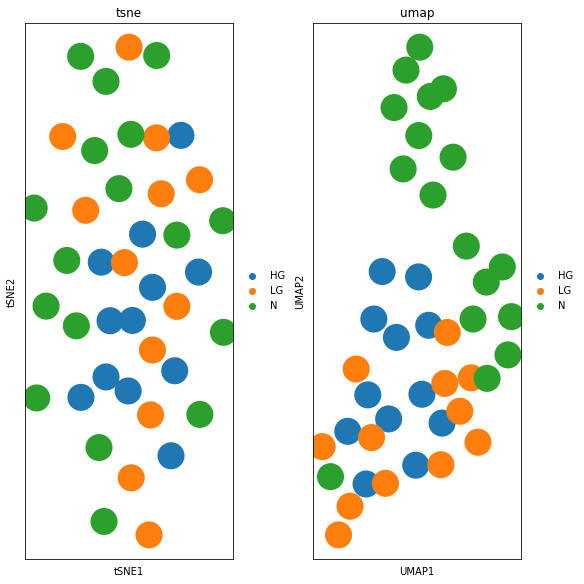

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8), constrained_layout=True)
sc.pl.tsne(ann_fd, color="patients_type", title="tsne", ax=axs[0], show=False)
sc.pl.umap(ann_fd, color="patients_type", title="umap", ax=axs[1], show=False)

## Using Combat

In [21]:
# create a new object with lognormalized counts
ann_fd_combat = sc.AnnData(X=ann_fd.X, var=ann_fd.var, obs = ann_fd.obs)


# first store the raw data 
ann_fd_combat.raw = ann_fd_combat

# run combat
sc.pp.combat(ann_fd_combat, key='patients_type')

In [22]:
var_genes_combat = ann_fd_combat.var.highly_variable
print("With combat:", sum(var_genes_combat))

With combat: 0
